# <center>LLM - Detect AI Generated Text</center>

This competition challenges participants to develop a machine learning model that can accurately detect **whether an essay was written by a student or an LLM**. The competition dataset comprises a mix of student-written essays and essays generated by a variety of LLMs.

Team Members: 毛柏毅, 朱誼學, 許木羽, 張立誠

In [1]:
# %pip install transformers
# %pip install peft
# %pip install bitsandbytes
# %pip install accelerate
# %pip install omegaconf
# %pip install lightgbm

## Configuration

In [2]:
import transformers as T
from datasets import Dataset
import torch
# from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import numpy as np

import os
import gc
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML

In [3]:
from typing import Literal

HOST: Literal['Localhost', 'Interactive', 'Batch'] = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
IS_RERUN: bool = os.getenv('KAGGLE_IS_COMPETITION_RERUN')

print(f'HOST: {HOST}, IS_RERUN: {IS_RERUN}')

HOST: Localhost, IS_RERUN: None


In [4]:
device = torch.device(
    ("cuda:3" if torch.cuda.is_available()
     else "mps" if torch.backends.mps.is_available()
     else "cpu"))

## Data

In [5]:
def get_kaggle_csv(dataset: str, name: str, is_comp: bool = False) -> pd.DataFrame:
    assert name.endswith('.csv')
    if IS_RERUN:
        return pd.read_csv(f'/kaggle/input/{dataset}/{name}')
    if is_comp:
        path = kagglehub.competition_download(dataset)
    else:
        path = kagglehub.dataset_download(dataset)
    return pd.read_csv(Path(path) / name)

In [6]:
if IS_RERUN:
    df_train = get_kaggle_csv('daigt-datamix', 'train_essays.csv')
    df_test = get_kaggle_csv('llm-detect-ai-generated-text', 'test_essays.csv', is_comp=True)
else:
    df_train = get_kaggle_csv('dogeon188/daigt-datamix', 'train_essays.csv')
    # split df_train into train and test
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_train.iloc[-10000:]
    df_train = df_train.iloc[:-10000]
df_train = df_train[df_train['source'] != 'unknown']

## Model

### Preprocess Data

In [7]:
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers

VOCAB_SIZE = 30000
LOWERCASE = False

raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(
    vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

ds_test = Dataset.from_pandas(df_test[['text']])
ds_train = Dataset.from_pandas(df_train[['text']])


def train_corp_iter():
    for i in range(0, len(ds_test), 1000):
        yield ds_test[i: i + 1000]["text"]
    # for i in range(0, len(ds_train), 1000):
    #     yield ds_train[i: i + 1000]["text"]


raw_tokenizer.train_from_iterator(
    train_corp_iter(),
    trainer=trainer,
    # length=len(ds_test) + len(ds_train)
)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_test = [tokenizer.tokenize(text)
                        for text in tqdm(df_test['text'])]
tokenized_texts_train = [tokenizer.tokenize(text)
                         for text in tqdm(df_train['text'])]

  0%|          | 0/10000 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 89833/89833 [01:10<00:00, 1270.68it/s]


### TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


def dummy(x): return x


vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',
    tokenizer=dummy, preprocessor=dummy,
    token_pattern=None, strip_accents='unicode')

vectorizer.fit(tqdm(tokenized_texts_test))

# Getting vocab
vocab = vectorizer.vocabulary_

vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
    analyzer='word', tokenizer=dummy, preprocessor=dummy,
    token_pattern=None, strip_accents='unicode'
)

tf_train = vectorizer.fit_transform(tqdm(tokenized_texts_train))
tf_test = vectorizer.transform(tqdm(tokenized_texts_test))

del vocab, vectorizer, tokenized_texts_train, tokenized_texts_test
gc.collect()

100%|██████████| 10000/10000 [00:07<00:00, 1351.79it/s]


0

In [9]:
y_train = df_train['source']


In [10]:
# reduce with TruncatedSVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_train = svd.fit_transform(tf_train)
X_test = svd.transform(tf_test)

In [ ]:
# visualize with t-SNE
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)

df_embedded = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_embedded['source'] = y_train

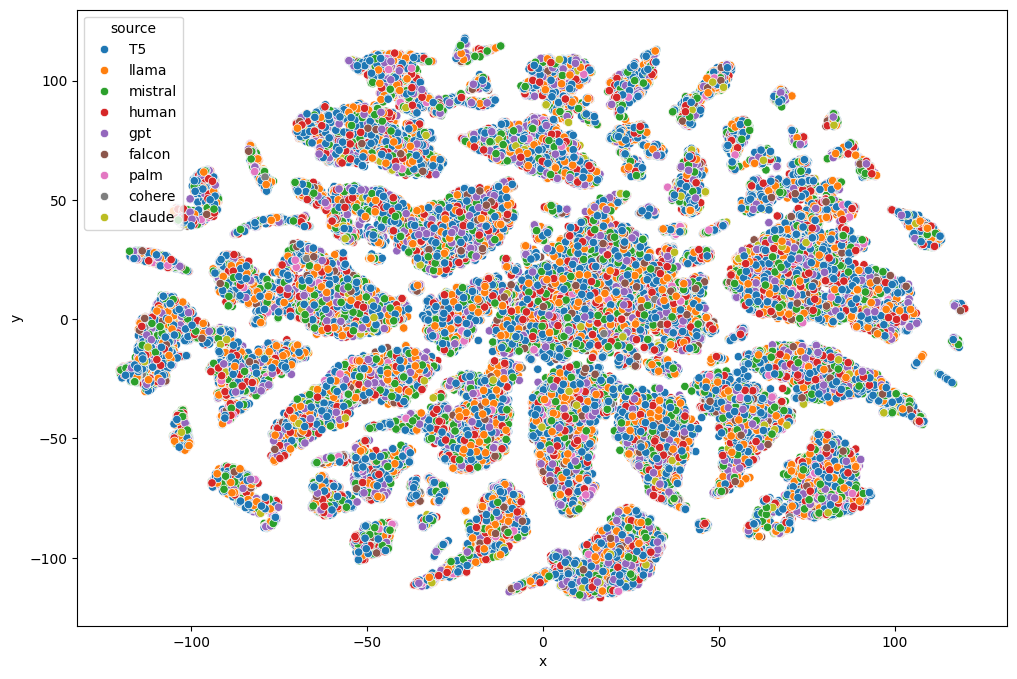

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_embedded, x='x', y='y', hue='source')
plt.show()